在本節中，我們將深入探索如何使用深度學習中的循環神經網絡（RNN），特別是長短期記憶網絡（LSTM），來進行時間序列數據的預測。我們將使用PyTorch框架，從數據預處理、模型構建、訓練到評估，完整地演示如何應用LSTM模型進行股票價格預測。
![https://ithelp.ithome.com.tw/upload/images/20240930/20120549DigLZPmvLx.png](https://ithelp.ithome.com.tw/upload/images/20240930/20120549DigLZPmvLx.png)

In [ ]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib

# 改style要在改font之前
# plt.style.use('seaborn')

matplotlib.font_manager.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')

--2024-10-11 04:24:06--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 142.251.2.139, 142.251.2.113, 142.251.2.100, ...
Connecting to drive.google.com (drive.google.com)|142.251.2.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2024-10-11 04:24:06--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.137.132, 2607:f8b0:4023:c03::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.137.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  78.9MB/s    in 0.2s    

2024-10-11 04:24:09 (

### **一、引言**

#### **1. 時間序列數據的特殊性**

- **時間依賴性**：時間序列數據的當前值與其過去的值密切相關。
- **非平穩性**：金融時間序列通常具有趨勢、季節性和波動性等特點。
- **高噪聲**：市場受多種因素影響，數據中可能存在大量噪聲。

#### **2. 為什麼選擇RNN和LSTM**

- **RNN（循環神經網絡）**：擅長處理序列數據，能夠捕捉時間序列中的依賴關係。
- **LSTM（長短期記憶網絡）**：一種特殊的RNN，解決了普通RNN的長程依賴和梯度消失問題，更適合處理長序列數據。

#### **3. PyTorch簡介**

- [**PyTorch**](https://pytorch.org/) 是一個開源的深度學習框架，由Facebook的人工智慧研究小組開發。它具有以下特點：

  - **動態計算圖**：允許在運行時改變網絡的結構，方便調試和開發。
  - **高效的張量運算**：支持GPU加速，能夠處理大型的數據和模型。
  - **豐富的社區資源**：擁有大量的教程、範例和第三方庫，便於學習和使用。

*在本節中，我們將使用PyTorch來構建和訓練LSTM模型，進行股票價格的預測。*
![https://ithelp.ithome.com.tw/upload/images/20240930/20120549JapVx4w2xK.png](https://ithelp.ithome.com.tw/upload/images/20240930/20120549JapVx4w2xK.png)
可以藉由下面指令來安裝：
```python
pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
```
另外須注意 `Pytorch` 本身需要注意自身環境的配置來選取對應的[安裝指令](https://pytorch.org/get-started/locally/)，更多[以前的 `Pytorch` 版本安裝](https://pytorch.org/get-started/previous-versions/)也可這個連結。
![https://ithelp.ithome.com.tw/upload/images/20240930/20120549eNf391EEf6.png](https://ithelp.ithome.com.tw/upload/images/20240930/20120549eNf391EEf6.png)
另外深度學習的相關知識也可以參考[連結1](https://ithelp.ithome.com.tw/articles/10321650)、[連結2](https://ithelp.ithome.com.tw/articles/10322059)、[連結3](https://www.youtube.com/watch?v=zuiACAhRUzA&ab_channel=%E9%99%B3%E7%B8%95%E5%84%82VivianNTUMiuLab)
#### **4. LSTM 簡介**

- **LSTM（長短期記憶網絡）** 是一種特殊的循環神經網絡，由 Hochreiter 和 Schmidhuber 於 1997 年提出，專門用於解決長期依賴問題。

- **LSTM 的核心特點**：

  - **記憶單元（Cell State, `C`）**：負責長期信息的傳遞，能夠保留重要的歷史信息。
  - **門控機制**：包含遺忘門、輸入門和輸出門，控制信息在網絡中的流動。
    - **遺忘門（Forget Gate, `f`）**：決定需要遺忘多少舊信息。
    - **輸入門（Input Gate, `i`）**：決定有多少新信息需要寫入記憶單元。
    - **輸出門（Output Gate, `O`）**：決定輸出多少信息到下一個時間步。

- **為什麼 LSTM 適合時間序列預測**：

  - **長期依賴建模**：能夠有效捕捉長期的時間依賴性，適合處理長序列數據。
  - **解決梯度消失和爆炸問題**：通過門控機制，緩解了 RNN 中常見的梯度問題。
  - **靈活性**：可應用於各種序列任務，如語音識別、機器翻譯和時間序列預測等。
 ![https://ithelp.ithome.com.tw/upload/images/20240930/2012054964gUgpc4OT.jpg](https://ithelp.ithome.com.tw/upload/images/20240930/2012054964gUgpc4OT.jpg)

*接下來，我們將利用 LSTM 的這些特性，構建一個用於股票價格預測的深度學習模型。*


---

### **二、數據準備**

#### **1. 數據獲取**

我們將使用`yfinance`庫獲取蘋果公司（AAPL）的股票數據。

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf

# 獲取數據
data = yf.download('AAPL', start='2015-01-01', end='2021-01-01')

# 提取收盤價
data = data[['Adj Close']]
data.rename(columns={'Adj Close': 'Close'}, inplace=True)

[*********************100%***********************]  1 of 1 completed
<ipython-input-3-07b601ef8701>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={'Adj Close': 'Close'}, inplace=True)


In [ ]:
data

,Close
Date,
2015-01-02,24.373960
2015-01-05,23.687302
2015-01-06,23.689529
2015-01-07,24.021713
2015-01-08,24.944689
...,...
2020-12-24,129.189529
2020-12-28,133.810074
2020-12-29,132.028381


#### **2. 數據可視化**


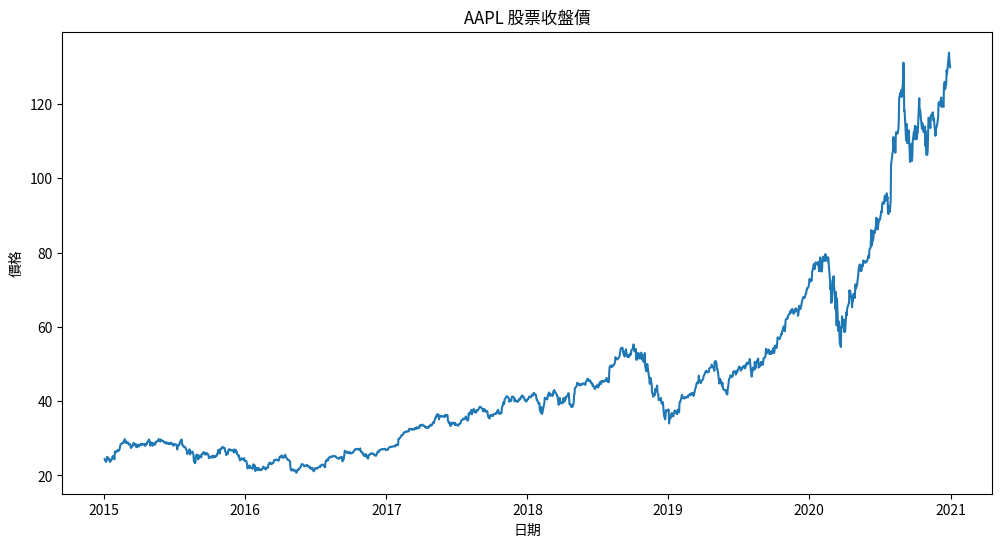

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(data['Close'])
plt.title('AAPL 股票收盤價')
plt.xlabel('日期')
plt.ylabel('價格')
plt.show()

#### **3. 數據歸一化**

為了提高模型訓練的效率，我們需要將數據歸一化到 `[0,1]` 區間。

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
data['Close'] = scaler.fit_transform(data[['Close']])

<ipython-input-8-f5cfbf6ee404>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Close'] = scaler.fit_transform(data[['Close']])


In [ ]:
data['Close']

,Close
Date,
2015-01-02,0.032310
2015-01-05,0.026238
2015-01-06,0.026258
2015-01-07,0.029195
2015-01-08,0.037357
...,...
2020-12-24,0.959143
2020-12-28,1.000000
2020-12-29,0.984245


#### **4. 創建數據集**

我們需要將時間序列數據轉換為監督學習的問題，即輸入特徵和目標值。

- **定義時間步長（lookback）**：決定了我們使用過去多少天的數據來預測下一天的價格。

In [ ]:
def create_dataset(dataset, lookback=60):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        X.append(dataset[i:(i+lookback), 0])
        y.append(dataset[i+lookback, 0])
    return np.array(X), np.array(y)

# 轉換為numpy數組
dataset = data.values

# 定義lookback窗口大小
lookback = 60

X, y = create_dataset(dataset, lookback)

In [ ]:
print(X.shape)
print(y.shape)

(1451, 60)
(1451,)


#### **5. 劃分訓練集和測試集**
我們分資料的方式先簡單用前面 8 成的資料當做訓練，後面2成資料當作測試

In [ ]:
# 劃分比例
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

#### **6. 數據格式調整**

PyTorch的RNN模型需要輸入形狀為 `(batch_size, seq_length, input_size)`。

In [ ]:
# 調整輸入形狀
X_train = X_train.reshape(-1, lookback, 1) # X_train[i:i+batch_size]
X_test = X_test.reshape(-1, lookback, 1)

In [ ]:
print("X_train",X_train.shape)
print("y_train",y_train.shape)
print("X_test",X_test.shape)
print("y_test",y_test.shape)

X_train (1160, 60, 1)
y_train (1160,)
X_test (291, 60, 1)
y_test (291,)



### **三、構建LSTM模型**

#### **1. 導入PyTorch**

In [ ]:
import torch
import torch.nn as nn

#### **2. 檢查GPU**


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'使用設備：{device}')

使用設備：cuda


#### **3. 定義LSTM模型 & 輸入和輸出說明**


In [ ]:
class StockPriceLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2):
        super(StockPriceLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # 定義LSTM層
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        # 定義全連接層
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # 初始化隱藏狀態和細胞狀態
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # 前向傳播LSTM
        out, _ = self.lstm(x, (h0, c0))
        # 取最後一個時間步的輸出
        out = self.fc(out[:, -1, :])
        return out

- **輸入（Input）**：
​
  - **x**：形狀為 `(batch_size, seq_length, input_size)` 的張量。
    - **batch_size**：一次訓練中使用的樣本數。
    - **seq_length（lookback）**：時間步長，即我們使用過去多少天的數據。
    - **input_size**：每個時間步的特徵數，這裡是 `1`，表示收盤價。
​
- **輸出（Output）**：
​
  - **out**：形狀為 `(batch_size, 1)` 的張量。
    - **預測值**：模型對下一天價格的預測。
​
- **流程**：
​
  1. **初始化隱藏狀態和細胞狀態**：
​
     ```python
     h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
     c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
     ```
​
     - **h0** 和 **c0**：分別是隱藏層和細胞狀態，初始化為零。
​
  2. **LSTM 層計算**：
​
     ```python
     out, _ = self.lstm(x, (h0, c0))
     ```
​
     - **out**：形狀為 `(batch_size, seq_length, hidden_size)`，包含每個時間步的輸出。
​
  3. **取最後一個時間步的輸出**：
​
     ```python
     out = self.fc(out[:, -1, :])
     ```
​
     - **out[:, -1, :]**：取得最後一個時間步的輸出，形狀為 `(batch_size, hidden_size)`。
     - **self.fc**：全連接層，將輸出映射到最終的預測值。

#### **4. 實例化模型**


In [ ]:
model = StockPriceLSTM().to(device)


#### **5. 定義損失函數和優化器**


In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### **四、訓練模型**

#### **1. 轉換數據為PyTorch的Tensor**


In [ ]:
X_train_tensor = torch.from_numpy(X_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)
X_test_tensor = torch.from_numpy(X_test).float().to(device)
y_test_tensor = torch.from_numpy(y_test).float().to(device)

#### **2. 開始訓練**


In [ ]:
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensor)
    optimizer.zero_grad()
    loss = criterion(outputs.squeeze(), y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        # 在測試集上評估
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_loss = criterion(test_outputs.squeeze(), y_test_tensor)
        print(f'Epoch [{epoch+1}/{num_epochs}], 訓練集Loss: {loss.item():.4f}, 測試集Loss: {test_loss.item():.4f}')

Epoch [10/500], 訓練集Loss: 0.0103, 測試集Loss: 0.2787
Epoch [20/500], 訓練集Loss: 0.0091, 測試集Loss: 0.2215
Epoch [30/500], 訓練集Loss: 0.0082, 測試集Loss: 0.2726
Epoch [40/500], 訓練集Loss: 0.0072, 測試集Loss: 0.2347
Epoch [50/500], 訓練集Loss: 0.0070, 測試集Loss: 0.2147
Epoch [60/500], 訓練集Loss: 0.0066, 測試集Loss: 0.2172
Epoch [70/500], 訓練集Loss: 0.0060, 測試集Loss: 0.1863
Epoch [80/500], 訓練集Loss: 0.0051, 測試集Loss: 0.1462
Epoch [90/500], 訓練集Loss: 0.0027, 測試集Loss: 0.0206
Epoch [100/500], 訓練集Loss: 0.0012, 測試集Loss: 0.0280
Epoch [110/500], 訓練集Loss: 0.0007, 測試集Loss: 0.0047
Epoch [120/500], 訓練集Loss: 0.0003, 測試集Loss: 0.0080
Epoch [130/500], 訓練集Loss: 0.0003, 測試集Loss: 0.0047
Epoch [140/500], 訓練集Loss: 0.0002, 測試集Loss: 0.0052
Epoch [150/500], 訓練集Loss: 0.0002, 測試集Loss: 0.0063
Epoch [160/500], 訓練集Loss: 0.0002, 測試集Loss: 0.0084
Epoch [170/500], 訓練集Loss: 0.0002, 測試集Loss: 0.0090
Epoch [180/500], 訓練集Loss: 0.0002, 測試集Loss: 0.0105
Epoch [190/500], 訓練集Loss: 0.0002, 測試集Loss: 0.0109
Epoch [200/500], 訓練集Loss: 0.0002, 測試集Loss: 0.0115
Epoch [21

### **五、評估模型**

#### **1. 預測並反歸一化**

In [ ]:
model.eval()
with torch.no_grad():
    train_predict = model(X_train_tensor).cpu().numpy()
    test_predict = model(X_test_tensor).cpu().numpy()

# 反歸一化
train_predict = scaler.inverse_transform(train_predict)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
print(train_predict)
print()
print(scaler.inverse_transform(dataset[lookback:])[0])

[[28.19105 ]
 [28.158373]
 [28.122921]
 ...
 [59.08586 ]
 [59.4427  ]
 [59.870842]]

[27.84982109]


#### **2. 繪製結果**


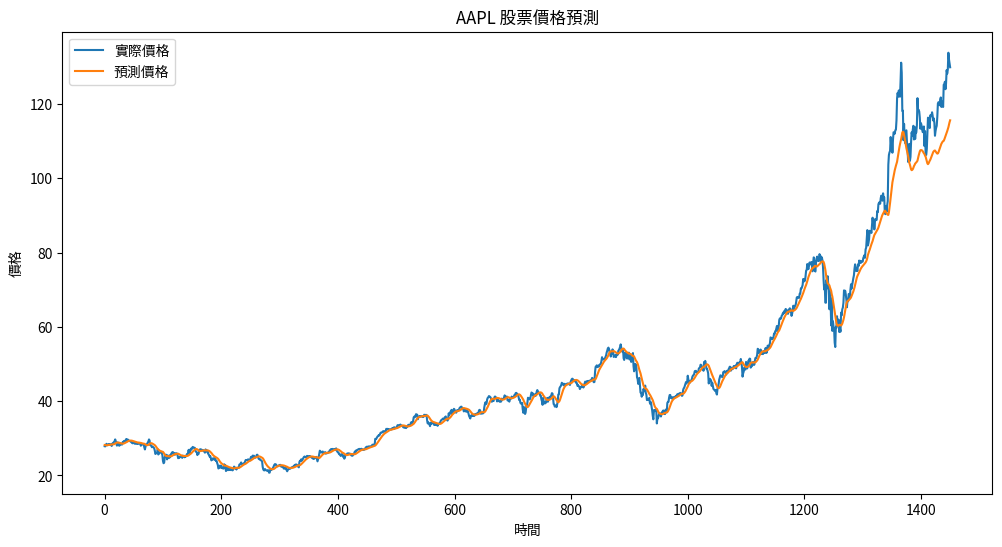

In [ ]:
# 構建完整的時間序列
predicted = np.concatenate((train_predict, test_predict), axis=0)
actual = scaler.inverse_transform(dataset[lookback:])

plt.figure(figsize=(12,6))
plt.plot(actual, label='實際價格')
plt.plot(predicted, label='預測價格')
plt.title('AAPL 股票價格預測')
plt.xlabel('時間')
plt.ylabel('價格')
plt.legend()
plt.show()

#### **3. 計算評價指標**


In [ ]:
from sklearn.metrics import mean_squared_error

train_score = mean_squared_error(y_train_actual, train_predict)
test_score = mean_squared_error(y_test_actual, test_predict)
print(f'訓練集MSE: {train_score:.2f}')
print(f'測試集MSE: {test_score:.2f}')

訓練集MSE: 1.39
測試集MSE: 51.87


### **六、處理時間序列數據的特殊性**

#### **1. 序列依賴性**

- **考慮過去的信息**：通過設置合理的`lookback`窗口大小，確保模型能夠捕捉足夠的歷史信息。
- **長期依賴問題**：LSTM結構能夠有效處理長期依賴，但也需要注意不要設置過大的`lookback`，以免增加模型複雜度。

#### **2. 數據平穩性**

- **趨勢和季節性**：可以使用差分或對數變換消除趨勢和季節性，但在LSTM中，這通常不是必須的，因為LSTM能夠處理非平穩數據。
- **歸一化**：歸一化能夠加速模型收斂，提高模型性能。

#### **3. 數據劃分**

- **時間序列切分**：確保訓練集在測試集之前，防止未來數據洩漏。
- **驗證集的使用**：可以從訓練集中再劃分出驗證集，用於超參數調整。

---

### **七、改進模型的方向**

#### **1. 超參數調整**

- **隱藏層大小**：嘗試不同的`hidden_size`，如`32`、`64`、`128`。
- **層數**：調整`num_layers`，如`1`、`2`、`3`。
- **學習率**：調整優化器的學習率，如`0.01`、`0.001`、`0.0001`。

#### **2. 增加正則化**
- **Dropout**：在LSTM層中添加`dropout`，防止過擬合。


In [ ]:
self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)

NameError: name 'nn' is not defined

#### **3. 增加特徵**
​
- **多變量輸入**：除了收盤價，還可以加入開盤價、最高價、最低價、成交量等特徵。
​

In [ ]:
# 例如，使用收盤價和成交量
data = data[['Close', 'Volume']]

- **技術指標**：添加移動平均線、相對強弱指數（RSI）等技術指標。

#### **4. 使用其他模型**

- **GRU（門控循環單元）**：與LSTM類似，但結構更簡潔，可以嘗試使用GRU。
- **CNN-LSTM**：將卷積神經網絡與LSTM結合，捕捉局部和全局特徵。

---

### **八、總結**

在本節中，我們：

- **了解了時間序列數據的特殊性**，以及為什麼選擇LSTM模型來進行預測。
- **簡要介紹了PyTorch**，並使用它構建了一個LSTM模型，應用於股票價格的預測。
- **從數據預處理到模型評估**，完整地演示了整個流程。
- **討論了處理時間序列數據的注意事項**，以及改進模型的方向。

*透過這次實踐，您應該對如何使用深度學習模型處理時間序列數據有了更深入的理解，並掌握了使用PyTorch進行模型構建和訓練的基本方法。*

---

**作業：**

1. **嘗試調整模型的超參數**：如`hidden_size`、`num_layers`、`learning_rate`，觀察對模型性能的影響。

2. **增加更多的特徵**：如技術指標、基本面數據，構建多變量時間序列模型。

3. **嘗試使用GRU模型**：將LSTM替換為GRU，比較兩者的性能。

4. **使用 Early Stopping 和學習率調整策略**：提高模型的泛化能力。

*透過這些練習，我們將能夠更靈活地應用深度學習模型進行時間序列預測，並提高模型的性能。*
---

**提示：**

- **檢查GPU是否可用**：在訓練深度學習模型時，使用GPU可以大大加速訓練過程。

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

- **防止過擬合**：在訓練過程中，監控訓練集和驗證集的損失，防止模型過擬合。

- **保存和加載模型**：使用`torch.save()`和`torch.load()`保存和加載模型，方便後續使用。

In [ ]:
# 保存模型
torch.save(model.state_dict(), 'model.pth')

# 加載模型
model.load_state_dict(torch.load('model.pth'))

<ipython-input-56-17f83192e929>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))


<All keys matched successfully>

**注意：**

- **數據預處理的重要性**：時間序列數據的質量直接影響模型的性能，務必仔細進行數據清洗和預處理。

- **模型的可解釋性**：深度學習模型通常是黑盒模型，難以解釋其內部機制。在金融領域，風險控制非常重要，需謹慎使用。

- **風險提示**：股票價格預測具有高度不確定性，模型預測結果僅供參考，不應作為投資決策的唯一依據。
